In [1]:
'''
https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial
'''
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def fix_values(df, fix_dict, col_name):
    for k, v in fix_dict.items():
        entry = df.loc[df[col_name] == k]
        entry[col_name] = v
        df.loc[df[col_name] == k] = entry

**TODO: We need to clean up our summary based on our current status**

`time_series_covid19_confirmed_global.csv`
- Latitude/longitude, time series confirmed cases
- Country code not in this file.
- Some country strings are not standard like:  "Korea, South"

`API_EN.POP.DNST_DS2_en_csv_v2_988966.csv`
- Population density for 2019. The 2020 information is not there.

`covid-19-tests-vs-cases-positivity-comparisons.csv`
- Tests that came out positivve
- Missing a lot of numbers for how many tests were performed. We need to grab these numbers from `full-list-covid-19-tests-per-day.csv`


**Plan of action?**

- Are we planning to use the regions/province data? Or will we consolidate it into one country.
- Should we combined all the the fields we want into a single file?
- We need mapping of country codes to country names. Let’s pick one file that looks sane and use it. Then we have to map country names from `time_series_covid19_confirmed_global.csv` back to the correct code.
- We should normalize the start/end dates. We need to get the intersection of start/end dates for all files and only use that.

In [3]:
# The number of confirmed cases per country in a time series format
confirmed_df = pd.read_csv("datasets/time_series_covid19_confirmed_global.csv")

# The number tests performed per day
# Automatically convert dates from column 3 (index 2) to DateTime objects
tests_df = pd.read_csv("datasets/full-list-covid-19-tests-per-day.csv", parse_dates=[2])

# The GDP per capita for each country for different years
gdp_capita_df = pd.read_csv('datasets/gdp.csv')

# The population, population density, and population (urban only) for each country
population_df = pd.read_csv('datasets/Populations_and_popdensity.csv')

# The centroid latitude and longitude coordinates for each country
centroids_df = pd.read_csv('datasets/country_centroids_az8.csv')

In [4]:
print("Confirmed shape: ", confirmed_df.shape)
confirmed_df.head()

Confirmed shape:  (264, 96)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25


In [5]:
print("Tests performed shape: ", tests_df.shape)
tests_df.head()

Tests performed shape:  (2683, 4)


,Entity,Code,Date,Daily change in total tests
0,Argentina,ARG,2020-04-09,1520
1,Argentina,ARG,2020-04-10,1529
2,Argentina,ARG,2020-04-11,1648
3,Argentina,ARG,2020-04-14,3047
4,Argentina,ARG,2020-04-15,1569


In [6]:
# Remove the province column because it will not be used
confirmed_df.drop("Province/State", axis=1, inplace=True)

# Inspect the country names to make sure they are sane
countries = confirmed_df["Country/Region"]
bad_countries = list(filter(lambda x: "," in x or "*" in x, countries))
print("Bad country strings: ", bad_countries)

# Through manual inspection, we determined that we need to properly change these inconsistent values.
confirmed_fix_dict = {
    "Korea, South": "South Korea",
    "Taiwan*": "Taiwan",
    "US": "United States",
}
print("Bad country fix dict: ", confirmed_fix_dict)

# Fix the values
fix_values(confirmed_df, confirmed_fix_dict, "Country/Region")

# Inspect that the strings are fixed
print(countries[143])  # South Korea
print(countries[207])  # Taiwan
confirmed_df.head()  # Make sure the province column is removed

Bad country strings:  ['Korea, South', 'Taiwan*']
Bad country fix dict:  {'Korea, South': 'South Korea', 'Taiwan*': 'Taiwan', 'US': 'United States'}
South Korea
Taiwan


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25


In [7]:
# Find abnormal country names in the tests performed dataset
pivoted_tests_df = tests_df.pivot(index="Entity", columns="Date", values=["Daily change in total tests"])
abnormal_country_names = list(filter(lambda x: "," in x, pivoted_tests_df.index))
print("Abnormal country names: ")
abnormal_country_names

Abnormal country names: 


['India, people tested',
 'Italy, people tested',
 'Japan, tests performed',
 'United Kingdom, tests performed',
 'United States, specimens tested (CDC)']

In [8]:
# Ensure that all the abnormal country names are ok to remove. We need to check if the country name
# before the comma already exists in the DataFrame. If it does not, that means this is the only information
# we have on the country. We should normalize the country name for those names. If the normalized country
# name does exist as a row, we can remove all rows containing the abnormal country names.
unwanted_indexes = []
tests_fix_dict = {}
for acn in abnormal_country_names:
    normalized_country_name = acn.split(",")[0]
    norm_df = tests_df[tests_df["Entity"] == normalized_country_name]
    ac_df = tests_df[tests_df["Entity"] == acn]
    if norm_df.empty:
        # Keep track of country names we need to modify
        tests_fix_dict[acn] = normalized_country_name        
    else:
        # Accumulate a list of indexes we want to remove
        print("Adding country name to drop list:", acn)
        unwanted_indexes.extend(ac_df.index)
        
# It is important to apply conversions first before removing the unwanted rows. If you try to apply
# the conversions after dropping the row, the indexes would have changed and you would be modifying
# the wrong rows.
print("Tests fix dict:", tests_fix_dict)
fix_values(tests_df, tests_fix_dict, "Entity")
    
print("Unwanted indexes:", unwanted_indexes)
print("Shape before dropping:", tests_df.shape)
# Remove the unwanted rows from the original DataFrame
tests_df.drop(unwanted_indexes, inplace=True)
print("Shape after dropping:", tests_df.shape)
tests_df.head()

Adding country name to drop list: India, people tested
Adding country name to drop list: Italy, people tested
Adding country name to drop list: United Kingdom, tests performed
Adding country name to drop list: United States, specimens tested (CDC)
Tests fix dict: {'Japan, tests performed': 'Japan'}
Unwanted indexes: [916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 1105, 1106, 1107, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 26

,Entity,Code,Date,Daily change in total tests
0,Argentina,ARG,2020-04-09,1520
1,Argentina,ARG,2020-04-10,1529
2,Argentina,ARG,2020-04-11,1648
3,Argentina,ARG,2020-04-14,3047
4,Argentina,ARG,2020-04-15,1569


In [9]:
# Aggregate confirmed cases based on country. This dataset has duplicate countries that have might be tied
# to a different province or state. This however will also sum the latitude and longitudes. In our case 
# this does not matter because we will be replacing these values from another dataset.
group_confirmed_df = confirmed_df.groupby("Country/Region")
agg_confirmed_df = group_confirmed_df.sum()
agg_confirmed_df  # This is a normal DataFrame again with duplicate countries removed

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,...,665,714,784,840,906,933,996,1026,1092,1176
Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,...,467,475,494,518,539,548,562,584,609,634
Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,...,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,...,646,659,673,673,696,704,713,717,717,723
Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,...,19,19,19,19,19,24,24,24,24,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,...,308,308,374,374,402,418,437,449,466,474
Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [10]:
# Check abnormalities with country string name
gdp_countries = set(gdp_capita_df["Country Name"].values)
gdp_abnormal = list(filter(lambda x: "," in x, gdp_countries))
print("GDB abnormal country names:")
print(gdp_abnormal)

# After inspecting the difference between our `confirmed` and `gdp per capita` datasets, we came up with this
# dictionary
gdp_fix_dict = {
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam": "Brunei",
    "Congo, Dem. Rep.": "Congo (Kinshasa)",
    "Congo, Rep.": "Congo (Brazzaville)",
    "Czech Republic": "Czechia",
    "Egypt, Arab Rep.": "Egypt",
    "Gambia, The": "Gambia",
    "Hong Kong SAR, China": "Hong Kong",
    "Iran, Islamic Rep.": "Iran",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Macao SAR, China": "Macau",
    "Myanmar": "Burma",
    "Korea, Dem. People’s Rep.": "North Korea",
    "Korea, Rep.": "South Korea",
    "Russian Federation": "Russia",
    "Venezuela, RB": "Venezula",
    "Yemen, Rep.": "Yemen",
}

# Fix the values
print("\nGDP fix dict:")
print(gdp_fix_dict)
fix_values(gdp_capita_df, gdp_fix_dict, "Country Name")
gdp_capita_df.head()

GDB abnormal country names:
['Hong Kong SAR, China', 'Korea, Rep.', 'Congo, Dem. Rep.', 'Venezuela, RB', 'Micronesia, Fed. Sts.', 'Macao SAR, China', 'Iran, Islamic Rep.', 'Yemen, Rep.', 'Gambia, The', 'Korea, Dem. People’s Rep.', 'Egypt, Arab Rep.', 'Congo, Rep.', 'Bahamas, The']

GDP fix dict:
{'Bahamas, The': 'Bahamas', 'Brunei Darussalam': 'Brunei', 'Congo, Dem. Rep.': 'Congo (Kinshasa)', 'Congo, Rep.': 'Congo (Brazzaville)', 'Czech Republic': 'Czechia', 'Egypt, Arab Rep.': 'Egypt', 'Gambia, The': 'Gambia', 'Hong Kong SAR, China': 'Hong Kong', 'Iran, Islamic Rep.': 'Iran', 'Kyrgyz Republic': 'Kyrgyzstan', 'Lao PDR': 'Laos', 'Macao SAR, China': 'Macau', 'Myanmar': 'Burma', 'Korea, Dem. People’s Rep.': 'North Korea', 'Korea, Rep.': 'South Korea', 'Russian Federation': 'Russia', 'Venezuela, RB': 'Venezula', 'Yemen, Rep.': 'Yemen'}


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24985.993281,24713.698045,25025.099563,25533.569780,25796.380251,25239.600411,25630.266492,NaN,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773194,59.860874,58.458015,78.706388,82.095231,101.108305,...,591.162346,641.872034,637.165044,613.856333,578.466353,547.228110,556.302139,520.896603,NaN,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4615.468028,5100.095808,5254.882338,5408.410496,4166.979684,3506.072885,4095.812942,3432.385736,NaN,NaN
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4437.178067,4247.614279,4413.081743,4578.666720,3952.829458,4124.108907,4532.890162,5268.848504,NaN,NaN
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,41100.729938,38392.943901,40626.751632,42300.334128,36039.653496,37224.108916,39134.393371,42029.762737,NaN,NaN


In [11]:
# Using the `confirmed` dataset as the primary data source, see if the `tests` and `gdb` datasets are
# missing any countries that we need.
#
# *** We are using this function repeatedly to recheck for abnormalities again after the previous cleaning steps.
confirmed_countries = set(agg_confirmed_df.index)
#print("Confirmed countries:", confirmed_countries)
tests_countries = set(tests_df["Entity"].values)
#print("Tests countries:", tests_countries)
gdp_capita_countries = set(gdp_capita_df["Country Name"].values)
#print("GDP countries:", gdp_countries)

# Perform set operations to find useful information between `confirmed` and `tests` countries
common_confirmed_plus_tests = confirmed_countries & tests_countries
uncommon_confirmed_plus_tests = confirmed_countries ^ tests_countries
confirmed_minus_tests = confirmed_countries - tests_countries

# Perform set operations to find useful information between `confirmed` and `gdp` countries
common_confirmed_plus_gdp_capita = confirmed_countries & gdp_capita_countries
uncommon_confirmed_plus_gdp_capita = confirmed_countries ^ gdp_capita_countries
confirmed_minus_gdp_capita = confirmed_countries - gdp_capita_countries

# From the following output, the following is questionable and shouldn't be a country:
# Ships:  Diamond Princess, MS Zaandam
print("Countries missing in `GDP per capita` dataset:")
# TODO: How should we impute these values
confirmed_minus_gdp_capita

Countries missing in `GDP per capita` dataset:


{'Diamond Princess',
 'Holy See',
 'MS Zaandam',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Slovakia',
 'Syria',
 'Taiwan',
 'Venezuela',
 'Western Sahara'}

In [12]:
# Every country's `gdp per capita` is empty for 2019 so we can't use it.
print(gdp_capita_df.shape)
print("GDP NULL count for 2019:", gdp_capita_df["2019"].isnull().sum())

# Although we don't have every country in our `gdp per capita` dataset to match every country in the
# `confirmed` dataset, let's at least try to use the latest values for each that exist. We will start
# with the 2018 column and then fill any NaN countries that we need by searching the years backward.
gdp_capita_2018_df = gdp_capita_df[['Country Name','Country Code','2018']]
gdp_capita_2018_df.rename(columns={'2018': 'GDP per capita'}, inplace=True)
gdp_capita_null_df = gdp_capita_2018_df[gdp_capita_2018_df['GDP per capita'].isnull()]
gdp_capita_missing_data = set(gdp_capita_null_df["Country Name"].values)

# Check which countries are missing the `gdp per capita` for 2018. For these countries missing values for
# 2018, let's fill in the missing data for the latest year we can find.
remaining_countries = gdp_capita_missing_data & confirmed_countries

# Walk backwards to search and replace the data with the first one found
for country in remaining_countries:
    for i in range(2017, 1959, -1):
        year = str(i)
        country_gdp_capita = gdp_capita_df[gdp_capita_df["Country Name"] == country]
        if all(country_gdp_capita[year].notna()):
            temp_country = gdp_capita_2018_df[gdp_capita_2018_df["Country Name"] == country]
            temp_country["GDP per capita"] = country_gdp_capita[year]
            gdp_capita_2018_df[gdp_capita_2018_df["Country Name"] == country] = temp_country
            print(f"Found and replaced GDP per capita for {country} using {year} data")
            break

# Extract the data again to make sure the modification happened
gdp_capita_null_df = gdp_capita_2018_df[gdp_capita_2018_df['GDP per capita'].isnull()]
gdp_capita_missing_data = set(gdp_capita_null_df["Country Name"].values)
remaining_countries = gdp_capita_missing_data & confirmed_countries

# This set should be empty
print(remaining_countries)

# This is the DataFrame we should be using from now on for merges
gdp_capita_2018_df.head()

(264, 65)
GDP NULL count for 2019: 264
Found and replaced GDP per capita for Eritrea using 2011 data
Found and replaced GDP per capita for South Sudan using 2015 data
Found and replaced GDP per capita for San Marino using 2017 data
Found and replaced GDP per capita for Iran using 2017 data
Found and replaced GDP per capita for Liechtenstein using 2016 data
set()


,Country Name,Country Code,GDP per capita
0,Aruba,ABW,NaN
1,Afghanistan,AFG,520.896603
2,Angola,AGO,3432.385736
3,Albania,ALB,5268.848504
4,Andorra,AND,42029.762737


In [13]:
# Inspect the dataset
population_df.head()

,Country/Region,Population,Density,Urban Population
0,Afghanistan,38928346,60,9732086.50
1,Albania,2877797,105,1813012.11
2,Algeria,43851044,18,32011262.12
3,American Samoa,55191,276,48568.08
4,Andorra,77265,164,67993.20


In [14]:
# Find common/uncommon countries between `population` and `confirmed` datasets
population_countries = set(population_df["Country/Region"].values)
population_missing = confirmed_countries - population_countries
print("Population dataset is missing:", population_missing)

# Through manual inspection we have created this dictionary to fix the country strings
population_fix_dict = {
    "Brunei ": "Brunei",
    "Côte d'Ivoire": "Cote d'Ivoire",
    "Czech Republic (Czechia)": "Czechia",
    "Congo": "Congo (Brazzaville)",
    "DR Congo": "Congo (Kinshasa)",
    "Myanmar": "Burma",
}

# Fix the values
print("\nPopulation fix dict:", population_fix_dict)
fix_values(population_df, population_fix_dict, "Country/Region")

# Verify that the fix worked
population_countries = set(population_df["Country/Region"].values)
remaining_missing = confirmed_countries - population_countries
print("\nPopulation dataset is missing:", remaining_missing)

Population dataset is missing: {'Saint Kitts and Nevis', 'Sao Tome and Principe', 'West Bank and Gaza', 'MS Zaandam', 'Congo (Kinshasa)', 'Diamond Princess', 'Burma', 'Brunei', 'Czechia', "Cote d'Ivoire", 'Kosovo', 'Congo (Brazzaville)', 'Saint Vincent and the Grenadines'}
Population fix dict: {'Brunei ': 'Brunei', "Côte d'Ivoire": "Cote d'Ivoire", 'Czech Republic (Czechia)': 'Czechia', 'Congo': 'Congo (Brazzaville)', 'DR Congo': 'Congo (Kinshasa)', 'Myanmar': 'Burma'}

Population dataset is missing: {'Saint Kitts and Nevis', 'Sao Tome and Principe', 'West Bank and Gaza', 'MS Zaandam', 'Diamond Princess', 'Brunei', 'Kosovo', 'Saint Vincent and the Grenadines'}


In [15]:
# Convert tests performed to time series
pivoted_tests_df = tests_df.pivot(index="Entity", columns="Date", values=["Daily change in total tests"])
pivoted_tests_df.head()

Daily change in total tests                                   \
Date                        2020-01-22 2020-01-24 2020-01-25 2020-01-26   
Entity                                                                    
Argentina                          NaN        NaN        NaN        NaN   
Australia                          NaN        NaN        NaN        NaN   
Austria                            NaN        NaN        NaN        NaN   
Bahrain                            NaN        NaN        NaN        NaN   
Bangladesh                         NaN        NaN        NaN        NaN   

                                                                              \
Date       2020-01-27 2020-01-28 2020-01-29 2020-01-30 2020-01-31 2020-02-01   
Entity                                                                         
Argentina         NaN        NaN        NaN        NaN        NaN        NaN   
Australia         NaN        NaN        NaN        NaN       17.0       19.0   
Austria           NaN        NaN        NaN        NaN        NaN        NaN   
Bahrain           NaN        NaN        NaN        NaN        NaN        NaN   
Bangladesh        NaN        NaN        NaN        NaN        NaN        NaN   

            ...                                                         \
Date        ... 2020-04-13 2020-04-14 2020-04-15 2020-04-16 2020-04-17   
Entity      ...                                                          
Argentina   ...        NaN     3047.0     1569.0     2083.0     2193.0   
Australia   ...     8195.0     4357.0     4884.0     8626.0    11527.0   
Austria     ...     3535.0     3384.0     5005.0     6015.0     6456.0   
Bahrain     ...     3354.0     3486.0     2459.0     3672.0     2668.0   
Bangladesh  ...     1570.0     1905.0     1740.0     2135.0     2190.0   

                                                                   
Date       2020-04-18 2020-04-19 2020-04-20 2020-04-21 2020-04-22  
Entity                                                             
Argentina      2292.0     1770.0     1856.0     2043.0     2617.0  
Australia     14980.0    14486.0    10749.0     8097.0    12599.0  
Austria        6660.0     3311.0     3706.0     6069.0    12776.0  
Bahrain        2956.0     4164.0     3575.0     4073.0     3416.0  
Bangladesh     2114.0     2634.0     2663.0     2974.0     3096.0  

[5 rows x 91 columns]

In [16]:
# If we really need to, we can reprocess the tests performed and positive data so that we get the epoch time instead
# We can convert the existing DateTime object to epoch time in seconds (however as a floating point).
# WARNING: Running this step multiple times will fail.
tests_df["Date"] = (tests_df["Date"] - datetime(1970,1,1)).dt.total_seconds()

In [17]:
# Get rate of increase based on confirmed cases
tp_confirmed_df = confirmed_df.transpose()
for i in tp_confirmed_df:
    tp_confirmed_df[i][4:] = tp_confirmed_df[i][4:].pct_change()
    
confirmed_rate_df = tp_confirmed_df.transpose()
confirmed_rate_df

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,Afghanistan,33,65,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0955519,0.0736842,0.0980392,0.0714286,0.0785714,0.0298013,0.0675241,0.0301205,0.0643275,0.0769231
1,Albania,41.1533,20.1683,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0470852,0.0171306,0.04,0.048583,0.0405405,0.0166976,0.0255474,0.0391459,0.0428082,0.0410509
2,Algeria,28.0339,1.6596,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0360502,0.0438729,0.0434783,0.05,0.0661376,0.0479735,0.0374901,0.0338532,0.0342163,0.0352188
3,Andorra,42.5063,1.5218,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0125392,0.0201238,0.0212443,0,0.0341753,0.0114943,0.0127841,0.0056101,0,0.0083682
4,Angola,-11.2027,17.8739,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0.263158,0,0,0,0.0416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,France,46.8852,-56.3159,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
260,South Sudan,6.877,31.307,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
261,Western Sahara,24.2155,-12.8858,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
262,Sao Tome and Principe,0.18636,6.61308,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


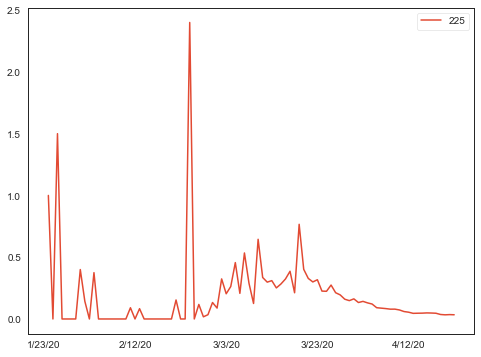

In [18]:
# USA: Percentage change per day based on the total confirmed from previous day
confirmed_rate_df[225:226].transpose()[4:].plot()

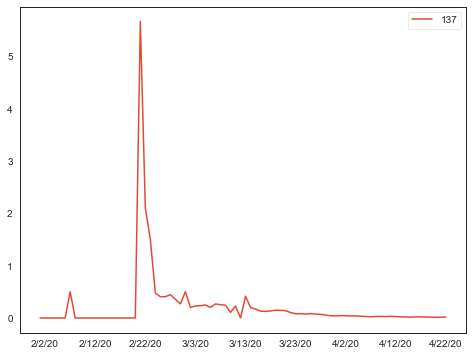

In [19]:
# Italy: Percentage change per day based on the total confirmed from previous day
confirmed_rate_df[137:138].transpose()[4:].plot()